In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'D2Coding'

In [162]:
# 파일 경로
baseball_file_new = '2022_야구경기.csv'
event_file_new = '2022_행사.csv'
station_file_new = '2022_종합운동장역_2호선_승하차.csv'

In [163]:
# 데이터 로드
baseball_data_new = pd.read_csv(baseball_file_new)
event_data_new = pd.read_csv(event_file_new)
station_data_new = pd.read_csv(station_file_new)

In [164]:
# 날짜 형식 통일 및 필요한 데이터 추출
baseball_data_new['경기날짜'] = pd.to_datetime(baseball_data_new['경기날짜'])
event_data_new['행사날짜'] = pd.to_datetime(event_data_new['행사날짜'])
station_data_new['수송일자'] = pd.to_datetime(station_data_new['수송일자'])
# 종합운동장역 데이터에서 '승차'와 '하차' 데이터로 분리
station_data_win_new = station_data_new[station_data_new['승하차구분'] == '승차']
station_data_lose_new = station_data_new[station_data_new['승하차구분'] == '하차']

In [165]:
# 각 시간대별 데이터 합산
station_data_win_new = station_data_win_new.melt(id_vars=['연번', '수송일자', '호선', '고유역번호(외부역코드)', '역명', '승하차구분'], var_name='시간대', value_name='승차수')
station_data_lose_new = station_data_lose_new.melt(id_vars=['연번', '수송일자', '호선', '고유역번호(외부역코드)', '역명', '승하차구분'], var_name='시간대', value_name='하차수')

station_data_win_new['수송일자'] = pd.to_datetime(station_data_win_new['수송일자'].astype(str) + ' ' + station_data_win_new['시간대'])
station_data_lose_new['수송일자'] = pd.to_datetime(station_data_lose_new['수송일자'].astype(str) + ' ' + station_data_lose_new['시간대'])
# 야구 경기와 행사 데이터를 하나의 데이터프레임으로 결합
event_data_new = event_data_new.rename(columns={'행사날짜': '날짜', '행사시작': '시작시간'})
event_data_new['종류'] = '행사'
baseball_data_new = baseball_data_new.rename(columns={'경기날짜': '날짜', '경기시작': '시작시간'})
baseball_data_new['종류'] = '경기'

merged_data_new = pd.concat([
    baseball_data_new[['날짜', '시작시간', '관중수', '종류']],
    event_data_new[['날짜', '시작시간', '관중수', '종류']]
])

In [166]:
# '날짜'와 '시작시간'을 합쳐 datetime 타입의 '행사시작' 열 생성
merged_data_new['시작시간'] = pd.to_datetime(merged_data_new['시작시간'], format='%H:%M').dt.time
merged_data_new['행사시작'] = pd.to_datetime(merged_data_new['날짜'].astype(str) + ' ' + merged_data_new['시작시간'].astype(str))

In [167]:
# 주말 여부 열 추가
merged_data_new['주말'] = merged_data_new['날짜'].dt.weekday >= 5

In [168]:
# 데이터 타입 변환
station_data_win_new['승차수'] = pd.to_numeric(station_data_win_new['승차수'], errors='coerce')
station_data_lose_new['하차수'] = pd.to_numeric(station_data_lose_new['하차수'], errors='coerce')

In [169]:
# 함수 정의: 행사 및 경기 시작 전 4시간 동안의 하차 수와 시작 후 1시간 후 4시간 동안의 승차 수 계산
def get_before_and_after_data_excluding_start(row):
    start_time = row['행사시작']
    start_time_before_3h = start_time - pd.Timedelta(hours=5)
    end_time_before = start_time
    start_time_after_1h = start_time + pd.Timedelta(hours=1)
    end_time_after_3h = start_time + pd.Timedelta(hours=5)  # 1시간 후부터 4시간을 포함하기 위해 5시간 추가
    
    # 4시간 동안 하차 수와 1시간 후 4시간 동안 승차 수 계산
    lose_before_sum = station_data_lose_new[(station_data_lose_new['수송일자'] >= start_time_before_3h) & (station_data_lose_new['수송일자'] < end_time_before)]['하차수'].sum()
    win_after_sum = station_data_win_new[(station_data_win_new['수송일자'] >= start_time_after_1h) & (station_data_win_new['수송일자'] < end_time_after_3h)]['승차수'].sum()
    
    return pd.Series([lose_before_sum, win_after_sum])

In [170]:
# 적용
hourly_data_excluding_start = merged_data_new.apply(get_before_and_after_data_excluding_start, axis=1)
hourly_data_excluding_start.columns = ['하차수_4시간동안', '승차수_1시간후_4시간동안']

# 관중수와 시간대별 승하차 수 데이터프레임 결합
final_data_excluding_start = pd.concat([merged_data_new, hourly_data_excluding_start], axis=1)


In [171]:
# 주말과 평일 데이터 분리
weekend_data = final_data_excluding_start[final_data_excluding_start['주말']]
weekday_data = final_data_excluding_start[final_data_excluding_start['주말'] == False]
# 상관관계 분석: 주말
correlation_matrix_weekend = weekend_data[['관중수', '하차수_4시간동안', '승차수_1시간후_4시간동안']].corr(numeric_only=True)
# 상관관계 분석: 평일
correlation_matrix_weekday = weekday_data[['관중수', '하차수_4시간동안', '승차수_1시간후_4시간동안']].corr(numeric_only=True)

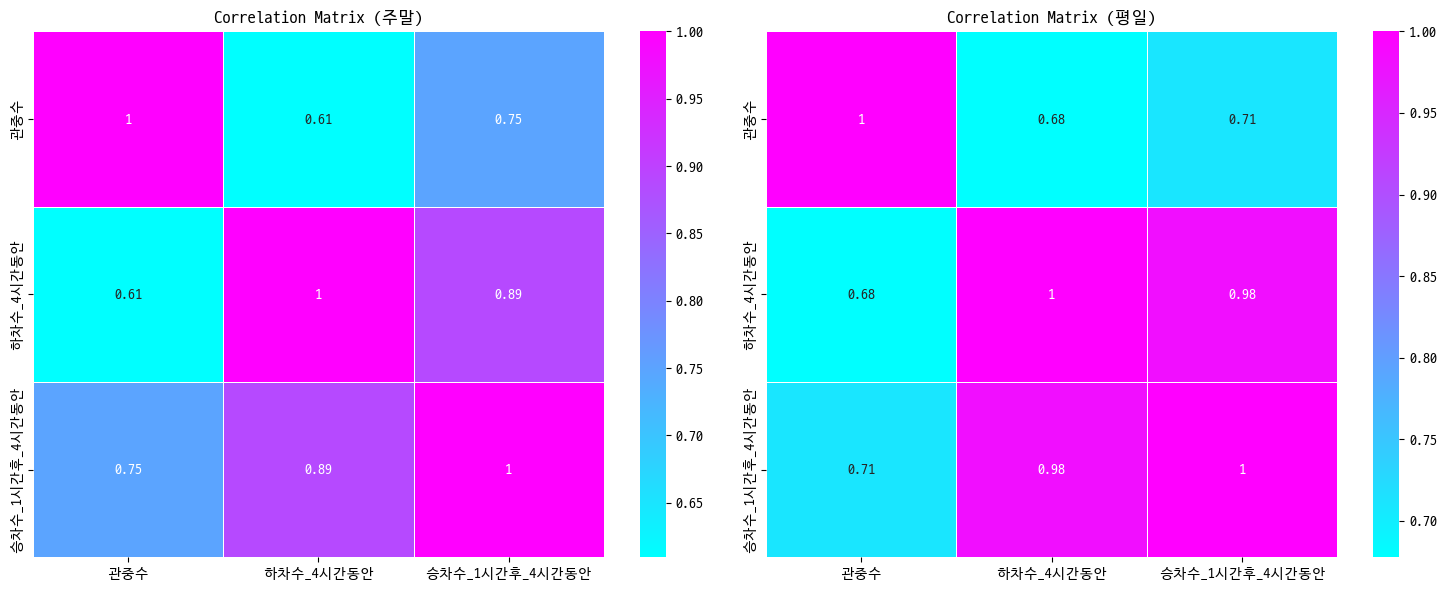

In [172]:
# 상관관계 히트맵 시각화
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(correlation_matrix_weekend, annot=True, cmap='cool', linewidths=0.5)
plt.title('Correlation Matrix (주말)')
plt.subplot(1, 2, 2)
sns.heatmap(correlation_matrix_weekday, annot=True, cmap='cool', linewidths=0.5)
plt.title('Correlation Matrix (평일)')
plt.tight_layout()
plt.show()


In [176]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

plt.rcParams['font.family'] = 'D2Coding'

# 파일 경로
baseball_file_new = '2022_야구경기.csv'
event_file_new = '2022_행사.csv'
station_file_new = '2022_종합운동장역_2호선_승하차.csv'

# 데이터 로드
baseball_data_new = pd.read_csv(baseball_file_new)
event_data_new = pd.read_csv(event_file_new)
station_data_new = pd.read_csv(station_file_new)

# 날짜 형식 통일 및 필요한 데이터 추출
baseball_data_new['경기날짜'] = pd.to_datetime(baseball_data_new['경기날짜'])
event_data_new['행사날짜'] = pd.to_datetime(event_data_new['행사날짜'])
station_data_new['수송일자'] = pd.to_datetime(station_data_new['수송일자'])

# 종합운동장역 데이터에서 '승차'와 '하차' 데이터로 분리
station_data_win_new = station_data_new[station_data_new['승하차구분'] == '승차']
station_data_lose_new = station_data_new[station_data_new['승하차구분'] == '하차']

# 각 시간대별 데이터 합산
station_data_win_new = station_data_win_new.melt(id_vars=['연번', '수송일자', '호선', '고유역번호(외부역코드)', '역명', '승하차구분'], var_name='시간대', value_name='승차수')
station_data_lose_new = station_data_lose_new.melt(id_vars=['연번', '수송일자', '호선', '고유역번호(외부역코드)', '역명', '승하차구분'], var_name='시간대', value_name='하차수')

station_data_win_new['수송일자'] = pd.to_datetime(station_data_win_new['수송일자'].astype(str) + ' ' + station_data_win_new['시간대'])
station_data_lose_new['수송일자'] = pd.to_datetime(station_data_lose_new['수송일자'].astype(str) + ' ' + station_data_lose_new['시간대'])

# 야구 경기와 행사 데이터를 하나의 데이터프레임으로 결합
event_data_new = event_data_new.rename(columns={'행사날짜': '날짜', '행사시작': '시작시간'})
event_data_new['종류'] = '행사'
baseball_data_new = baseball_data_new.rename(columns={'경기날짜': '날짜', '경기시작': '시작시간'})
baseball_data_new['종류'] = '경기'

merged_data_new = pd.concat([
    baseball_data_new[['날짜', '시작시간', '관중수', '종류']],
    event_data_new[['날짜', '시작시간', '관중수', '종류']]
])

# 같은 날짜에 여러 이벤트가 있는 경우 최대 관중 수를 사용
merged_data_new = merged_data_new.groupby('날짜').agg({
    '시작시간': 'first',
    '관중수': 'max',
    '종류': 'first'
}).reset_index()

# '날짜'와 '시작시간'을 합쳐 datetime 타입의 '행사시작' 열 생성
merged_data_new['시작시간'] = pd.to_datetime(merged_data_new['시작시간'], format='%H:%M').dt.time
merged_data_new['행사시작'] = pd.to_datetime(merged_data_new['날짜'].astype(str) + ' ' + merged_data_new['시작시간'].astype(str))

# 주말 여부 열 추가
merged_data_new['주말'] = merged_data_new['날짜'].dt.weekday >= 5

# 데이터 타입 변환
station_data_win_new['승차수'] = pd.to_numeric(station_data_win_new['승차수'], errors='coerce')
station_data_lose_new['하차수'] = pd.to_numeric(station_data_lose_new['하차수'], errors='coerce')

# 함수 정의: 행사 및 경기 시작 전 4시간 동안의 하차 수와 시작 후 1시간 후 4시간 동안의 승차 수 계산
def get_before_and_after_data_excluding_start(row):
    start_time = row['행사시작']
    start_time_before_4h = start_time - pd.Timedelta(hours=4)
    end_time_before = start_time
    start_time_after_1h = start_time + pd.Timedelta(hours=1)
    end_time_after_4h = start_time + pd.Timedelta(hours=5)  # 1시간 후부터 4시간을 포함하기 위해 5시간 추가
    
    # 4시간 동안 하차 수와 1시간 후 4시간 동안 승차 수 계산
    lose_before_sum = station_data_lose_new[(station_data_lose_new['수송일자'] >= start_time_before_4h) & (station_data_lose_new['수송일자'] < end_time_before)]['하차수'].sum()
    win_after_sum = station_data_win_new[(station_data_win_new['수송일자'] >= start_time_after_1h) & (station_data_win_new['수송일자'] < end_time_after_4h)]['승차수'].sum()
    
    return pd.Series([lose_before_sum, win_after_sum])

# 적용
hourly_data_excluding_start = merged_data_new.apply(get_before_and_after_data_excluding_start, axis=1)
hourly_data_excluding_start.columns = ['하차수_4시간동안', '승차수_1시간후_4시간동안']

# 관중수와 시간대별 승하차 수 데이터프레임 결합
final_data_excluding_start = pd.concat([merged_data_new, hourly_data_excluding_start], axis=1)

# 주말과 평일 데이터 분리
weekend_data = final_data_excluding_start[final_data_excluding_start['주말']]
weekday_data = final_data_excluding_start[final_data_excluding_start['주말'] == False]

# 선형 회귀 모델 학습 함수 정의
def train_linear_regression(data, feature, target):
    X = data[[feature]].values
    y = data[target].values
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    return model, rmse, r2

# 주말: 관중수 -> 하차수_4시간동안
weekend_model_hacha, weekend_rmse_hacha, weekend_r2_hacha = train_linear_regression(weekend_data, '관중수', '하차수_4시간동안')

# 주말: 관중수 -> 승차수_1시간후_4시간동안
weekend_model_seungcha, weekend_rmse_seungcha, weekend_r2_seungcha = train_linear_regression(weekend_data, '관중수', '승차수_1시간후_4시간동안')

# 평일: 관중수 -> 하차수_4시간동안
weekday_model_hacha, weekday_rmse_hacha, weekday_r2_hacha = train_linear_regression(weekday_data, '관중수', '하차수_4시간동안')

# 평일: 관중수 -> 승차수_1시간후_4시간동안
weekday_model_seungcha, weekday_rmse_seungcha, weekday_r2_seungcha = train_linear_regression(weekday_data, '관중수', '승차수_1시간후_4시간동안')

# 주말 관중이 20000명일 때 예상 하차수와 승차수
weekend_crowd = 20000
predicted_hacha_weekend = weekend_model_hacha.predict([[weekend_crowd]])[0]
predicted_seungcha_weekend = weekend_model_seungcha.predict([[weekend_crowd]])[0]

# 평일 관중이 20000명일 때 예상 하차수와 승차수
weekday_crowd = 20000
predicted_hacha_weekday = weekday_model_hacha.predict([[weekday_crowd]])[0]
predicted_seungcha_weekday = weekday_model_seungcha.predict([[weekday_crowd]])[0]


In [177]:

# 결과 출력
print("주말 관중이 20000명일 때 예상 하차수:", predicted_hacha_weekend)
print("주말 관중이 20000명일 때 예상 승차수:", predicted_seungcha_weekend)
print("주말 모델 RMSE (하차수):", weekend_rmse_hacha, "R^2 (하차수):", weekend_r2_hacha)
print("주말 모델 RMSE (승차수):", weekend_rmse_seungcha, "R^2 (승차수):", weekend_r2_seungcha)

print("\n평일 관중이 20000명일 때 예상 하차수:", predicted_hacha_weekday)
print("평일 관중이 20000명일 때 예상 승차수:", predicted_seungcha_weekday)
print("평일 모델 RMSE (하차수):", weekday_rmse_hacha, "R^2 (하차수):", weekday_r2_hacha)
print("평일 모델 RMSE (승차수):", weekday_rmse_seungcha, "R^2 (승차수):", weekday_r2_seungcha)

주말 관중이 20000명일 때 예상 하차수: 12601.632454455548
주말 관중이 20000명일 때 예상 승차수: 10586.935363011122
주말 모델 RMSE (하차수): 3547.928975915554 R^2 (하차수): 0.6025585554406454
주말 모델 RMSE (승차수): 3520.7667917970684 R^2 (승차수): 0.3948638853508535

평일 관중이 20000명일 때 예상 하차수: 13781.64672165865
평일 관중이 20000명일 때 예상 승차수: 11661.14396704705
평일 모델 RMSE (하차수): 2220.683867257144 R^2 (하차수): 0.7138281187277427
평일 모델 RMSE (승차수): 2178.981099295327 R^2 (승차수): 0.7011192501749921


c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


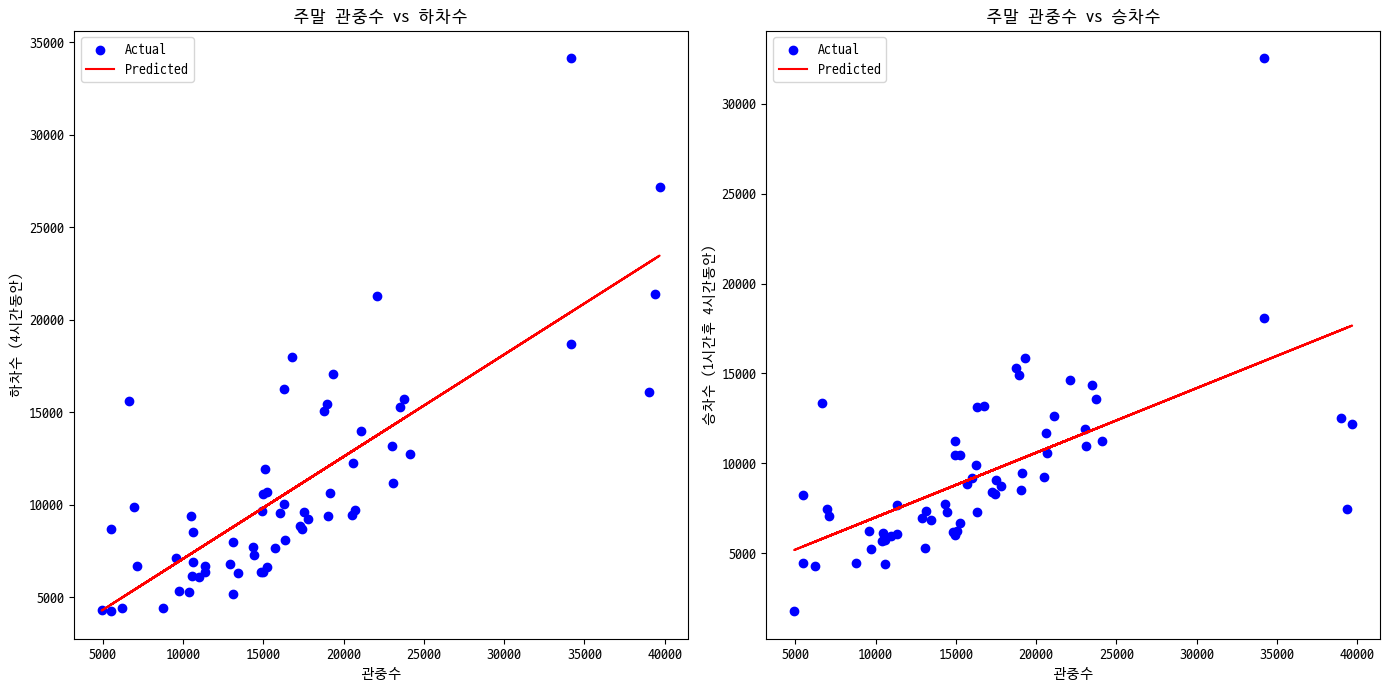

c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


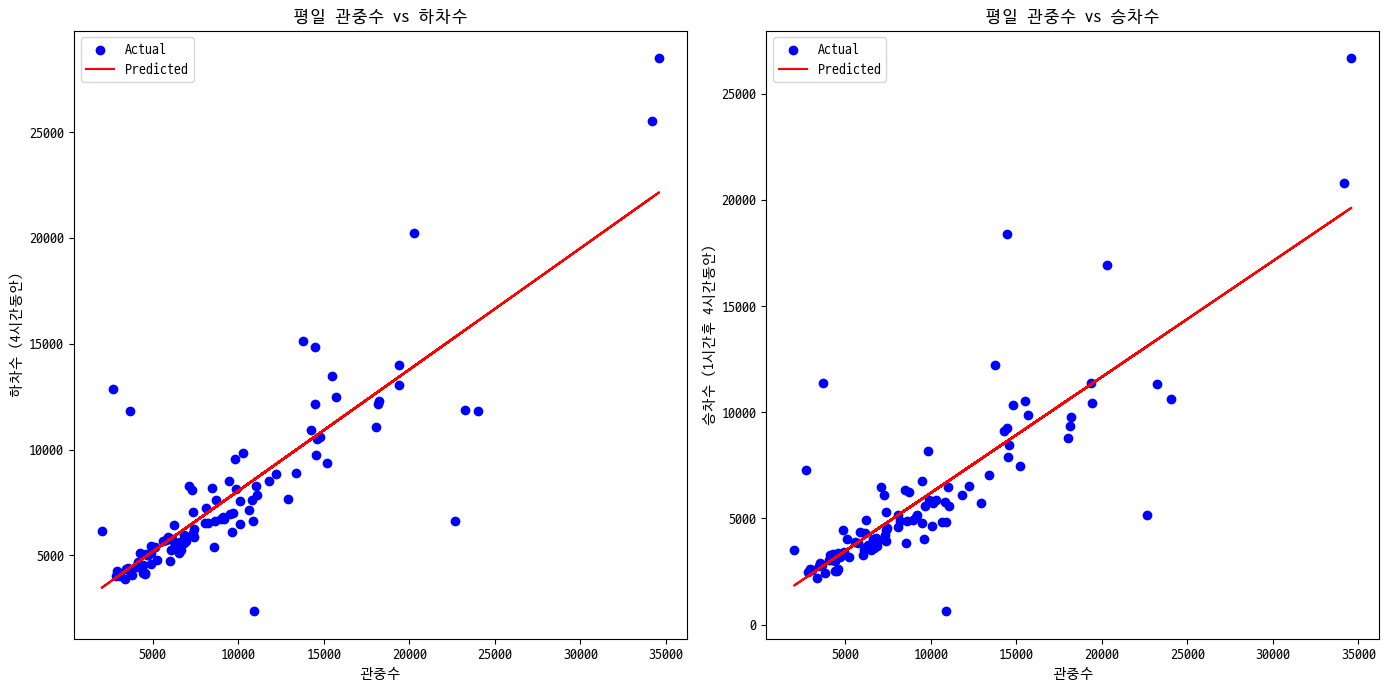

In [178]:
# 주말 데이터 시각화
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(weekend_data['관중수'], weekend_data['하차수_4시간동안'], color='blue', label='Actual')
plt.plot(weekend_data['관중수'], weekend_model_hacha.predict(weekend_data[['관중수']]), color='red', label='Predicted')
plt.xlabel('관중수')
plt.ylabel('하차수 (4시간동안)')
plt.title('주말 관중수 vs 하차수')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(weekend_data['관중수'], weekend_data['승차수_1시간후_4시간동안'], color='blue', label='Actual')
plt.plot(weekend_data['관중수'], weekend_model_seungcha.predict(weekend_data[['관중수']]), color='red', label='Predicted')
plt.xlabel('관중수')
plt.ylabel('승차수 (1시간후 4시간동안)')
plt.title('주말 관중수 vs 승차수')
plt.legend()

plt.tight_layout()
plt.show()

# 평일 데이터 시각화
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.scatter(weekday_data['관중수'], weekday_data['하차수_4시간동안'], color='blue', label='Actual')
plt.plot(weekday_data['관중수'], weekday_model_hacha.predict(weekday_data[['관중수']]), color='red', label='Predicted')
plt.xlabel('관중수')
plt.ylabel('하차수 (4시간동안)')
plt.title('평일 관중수 vs 하차수')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(weekday_data['관중수'], weekday_data['승차수_1시간후_4시간동안'], color='blue', label='Actual')
plt.plot(weekday_data['관중수'], weekday_model_seungcha.predict(weekday_data[['관중수']]), color='red', label='Predicted')
plt.xlabel('관중수')
plt.ylabel('승차수 (1시간후 4시간동안)')
plt.title('평일 관중수 vs 승차수')
plt.legend()

plt.tight_layout()
plt.show()